# Estimate Sobol' indices for the Ishigami function by a sampling method: a quick start guide to sensitivity analysis

In this example, we estimate the Sobol' indices for the Ishigami function by sampling methods. 

Let $a=7$ and $b=0.1$. We consider the function 

$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$

for any $X_1,X_2,X_3\in[-\pi,\pi]$ 

We assume that the random variables $X_1,X_2,X_3$ are independent and have the uniform marginal distribution in the interval from $-\pi$ to $\pi$:

$$
X_1,X_2,X_3\sim \mathcal{U}(-\pi,\pi).
$$

## Introduction

In this example we are going to quantify the correlation between the input variables and the output variable of a model thanks to the Sobol indices.

The Sobol indices allow to evaluate the importance of a single variable or a specific set of variables. Here the Sobol indices are estimated by sampling, from two input samples and a numerical function.

In theory, Sobol indices range is $\left[0; 1\right]$ ; the more the indice value is close to 1 the more the variable is important toward the output of the function. 

Let us denote by $d$ the input dimension of the model. 

The Sobol' indices can be computed at different orders.

* The first order indices evaluate the importance of one variable at a time.

* The $d$ total indices give the relative importance of every variables except the variable $X_i$, for every variable.

* In general, we are only interested in first order and total Sobol' indices. There are situations, however, where we want to estimate interactions. The second order indices evaluate the importance of every pair of variables; this represents 

$$
\binom{d}{2} = \frac{d \times \left( d-1\right) }{2}
$$ 

indices. 

In practice, when the number of input variables is not small (say, when $d>5$), then the number of second order indices is too large for being easy to analyze. In these situations, we limit the analysis to the first order and total Sobol' indices.

## Define the model

In [1]:
import openturns as ot
import numpy as np

Create the Ishigami test function.

In [2]:
ot.RandomGenerator.SetSeed(0)
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

Create the probabilistic model

In [3]:
inputDimension = 3
distributionList = [ot.Uniform(-np.pi, np.pi)] * inputDimension
distribution = ot.ComposedDistribution(distributionList)

## Draw the function

In [4]:
n = 10000
sampleX = distribution.getSample(n)
sampleY = g(sampleX)

In [5]:
def plotXvsY(sampleX, sampleY, figsize=(15,3)):
    import pylab as pl
    import openturns.viewer
    dimX = sampleX.getDimension()
    inputdescr = sampleX.getDescription()
    fig = pl.figure(figsize=figsize)
    for i in range(dimX):
        ax = fig.add_subplot(1, dimX, i+1)
        graph = ot.Graph('', inputdescr[i], 'Y', True, '')
        cloud = ot.Cloud(sampleX[:,i],sampleY)
        graph.add(cloud)
        _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    return None

plotXvsY(sampleX, sampleY)

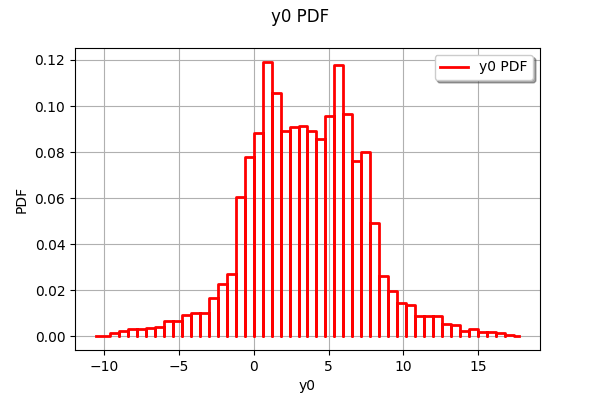

In [6]:
ot.HistogramFactory().build(sampleY).drawPDF()

We see that the distribution of the output has two modes. 

## Estimate the Sobol' indices

We first create a design of experiments with the `SobolIndicesExperiment`. Since we are not interested in the second order indices for the moment, we use the default value of the third argument (we will come back to this topic later).

In [7]:
size = 1000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
inputDesign.setDescription(input_names)
inputDesign.getSize()

5000

We see that 5000 function evaluations are required to estimate the first order and total Sobol' indices.

Then we evaluate the outputs corresponding to this design of experiments.

In [8]:
outputDesign = g(inputDesign)

Then we estimate the Sobol' indices with the `SaltelliSensitivityAlgorithm`. 

In [9]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

The `getFirstOrderIndices` and `getTotalOrderIndices` method returns the estimates of the Sobol' indices.

In [10]:
sensitivityAnalysis.getFirstOrderIndices()

class=Point name=Unnamed dimension=3 values=[0.334197,0.42868,-0.0246479]

In [11]:
sensitivityAnalysis.getTotalOrderIndices()

class=Point name=Unnamed dimension=3 values=[0.538721,0.440278,0.2622]

The `draw` method produces the following graphics. The vertical bars represents 95% confidence intervals of the estimates. 

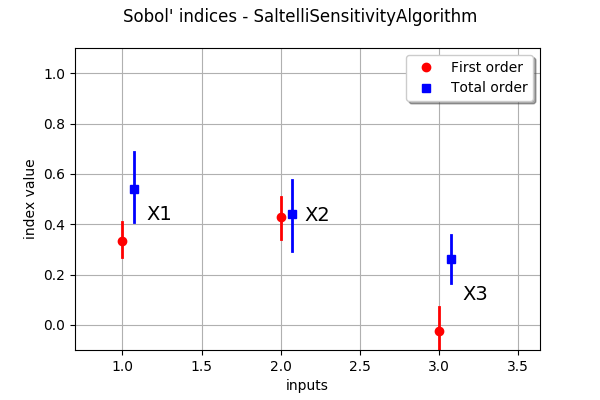

In [12]:
graph = sensitivityAnalysis.draw()
graph

- We see that the variable $X_1$, with a total Sobol' indice close to 0.6, is the most significant variable, taking into account its effet by itself or with its interactions with other variables. The first order indice is close to 0.3, which implies that, for the interactions (and only the interactions) produce almost 0.3 of the total variance. 
- The variable $X_2$ has the highest first order indice, but has no interactions since the total order indice is close to the first order indice. Its total Sobol' indice is approximately equal to 0.4. 
- The variable $X_3$ has a first order indice close to zero. However, it has an impact to the total variance thanks to its interactions with $X_1$. 
- We see that, because of the sampling, the variability of the Sobol' indices estimates is quite large, even with a relatively large sample size. Moreover, since the exact first order Sobol' indice for $X_3$ is zero, its estimate has 50% chance of being nonpositive. 

## Estimate the second order indices

In [13]:
size = 1000
computeSecondOrder = True
sie = ot.SobolIndicesExperiment(distribution, size, computeSecondOrder)
inputDesign = sie.generate()
print(inputDesign.getSize())
inputDesign.setDescription(input_names)
outputDesign = g(inputDesign)

8000


We see that 8000 function evaluations are now required; this is 3000 more evaluations than in the previous situation.

In [14]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [15]:
second_order = sensitivityAnalysis.getSecondOrderIndices()
for i in range(inputDimension):
    for j in range(i):
        print('2nd order indice (%d,%d)=%g' % (i,j,second_order[i,j]))

2nd order indice (1,0)=-0.0805798
2nd order indice (2,0)=0.0914596
2nd order indice (2,1)=-0.0988192


This shows that only the interaction between $X_1$ and $X_3$ is significant (beware of the index shift between the Python indice and the mathematical one).

## Using a different estimator

We have used the `SaltelliSensitivityAlgorithm` class to estimate the indices. Other classes are available in the library; the following list presents all the available estimators. 
* `SaltelliSensitivityAlgorithm`
* `MartinezSensitivityAlgorithm`
* `JansenSensitivityAlgorithm`
* `MauntzKucherenkoSensitivityAlgorithm`


In order to compare the results with another method, we use the `MartinezSensitivityAlgorithm` class.

In [16]:
sensitivityAnalysis = ot.MartinezSensitivityAlgorithm(inputDesign, outputDesign, size)

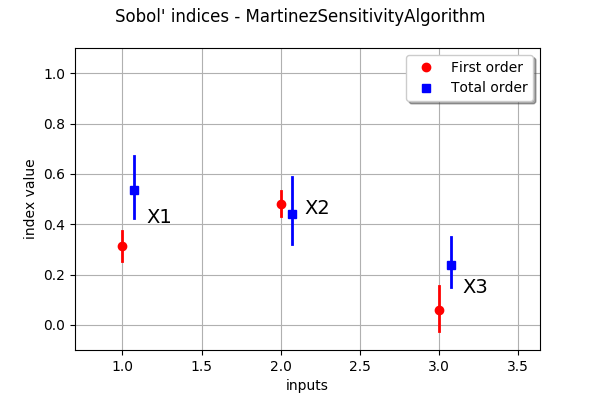

In [17]:
graph = sensitivityAnalysis.draw()
graph

We see that this does not change significantly the results in this particular situation.